# Modeling the World State

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S21_sorter_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U -q gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gtsam

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtbook
from gtbook.discrete import Variables
from gtbook.display import show

def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)

```{index} state; discrete state
```

> The physical properties of a piece of trash comprise all of the information needed by the robot.

<img src="Figures2/S21-Trash_sorting_robot_with_gripper-09.jpg" alt="Splash image with robot approaching a trash bin" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

For our simple trash sorting robot, the only thing that matters at a given moment is the category
of the item of trash on the conveyor belt. Remember that items of trash are presented individually to the robot,
so there is no clutter, and no circumstance in which multiple pieces of trash are simultaneously in the workspace.
Therefore, it is natural to define the world state explicitly in terms of the category of the current
item of trash. We consider five possible categories:
- cardboard
- paper
- can
- scrap metal
- bottle

For simplicity, we assume here that there will never be a piece of trash that does not belong to one of these categories.  We do not, however, assume that the category of an item can be reliably determined with 100% accuracy. 
Instead, we use probability theory to quantify the uncertainty associated to an object's categorization.

## Using Probability to Model Uncertainty

> Probability theory provides a rigorous methodology for reasoning about uncertainty.

We will use probability theory to model uncertainty.
While a comprehensive coverage of probability theory is beyond the scope of this book,
we introduce key concepts and methods throughout the text, as needed,
to deal with various kinds of uncertainty that occur in robotics applications.
Rigorous introductions can be found in many textbooks, including the book  ["Introduction to Probability for Data Science"](https://probability4datascience.com/index.html) {cite:p}`Chan23book_prob4ds` (which is available online).

```{index} sample space, outcome
```
The starting point for reasoning with uncertainty is to define the set of outcomes that might occur.
The set of all possible outcomes is called the **sample space**, often denoted by $\Omega.$
In our example, when an item of trash arrives on the conveyor belt,
there are five possible outcomes,
\begin{equation}
\Omega = \{ \rm{cardboard, paper, can, scrap \; metal, bottle}\}.
\end{equation}

```{index} event, probability distribution
```
## Probability Distributions
A subset of the sample space $\Omega$ is called an **event**.  A **probability distribution**, $P$, assigns a probability $0 \leq P(A) \leq 1$ to each event $A \subseteq \Omega$, with $P(\emptyset) = 0$ and $P(\Omega)=1$. 
In addition, for disjoint events, $A_i \cap A_j = \emptyset$, we have
$P(A_i \cup A_j) = P(A_i) + P(A_j)$.
Using this property, it is a simple matter to compute the probability for any $A \subseteq \Omega$
if we are provided with the probabilities of the individual outcomes.
Further, since $P(\Omega)=1$, it follows immediately that 
\begin{equation}
P(\Omega) = \sum_{\omega \in \Omega} P(\{\omega\}) = 1
\end{equation}
i.e., that the probabilities of the individual outcomes sum to unity.
As a slight abuse of notation, for singleton events, we will often write $P(\omega)$ rather than $P(\{\omega\})$
to simplify notation.

In robotics applications, the probability assigned to an outcome reflects our certainty in that outcome.
These probabilities can change based on the arrival of new evidence.
In robotics, this can occur when the robot acts in the world, or based on sensor data.
How evidence affects the propagation of probability values is a recurring topic in this book.

```{index} prior probability distribution
```

## Prior Probability Distributions
> A *prior* describes our beliefs before any sensor data is obtained.

Once we have enumerated the set of possible outcomes, we confront a fundamental question: *Where do the
probability values come from?* In this section we explicitly consider the notion of prior knowledge that is available in a particular application. High-quality "priors" can make a big difference in performance, especially when measurements are few or unreliable.

In some cases, we merely assume that all outcomes are equally likely, for example, when rolling a die or tossing coin.
In such cases, the probability of any outcome is merely $P(\omega) = 1/N$ for each $\omega \in \Omega$, where $N =| \Omega |$.
This leads to $P(\mathrm{heads}) = P(\mathrm{tails}) = 0.5$ when tossing a fair coin, 
where $\Omega = \{ \mathrm{heads, tails} \}$.

In other cases, we can estimate probabilities using data.
Suppose, for example, that the owner of the trash-sorting facility has told us (or we have kept statistics over time) that for every 1000 pieces of trash, the observed category counts are approximately as follows:
- cardboard: 200
- paper: 300
- can: 250
- scrap metal: 200
- bottle: 50

It is common to assume that outcomes occur in proportion to their probability. There are a number of
technical conditions that underlie this assumption, such as the condition that outcomes are independent,
but we will not address these here. Thus, from the above observed frequencies, we might estimate that the probability of seeing a piece of cardboard in the work cell is given by
\begin{equation}
P(\mathrm{cardboard}) \approx 200/1000 = 0.2
\end{equation}
Using the same logic, we can do this for all categories, yielding:

| *Category (C)* | *P(C)* |
|----------------|:------:|
| cardboard      |   0.20 |
| paper          |   0.30 |
| can            |   0.25 |
| scrap metal    |   0.20 |
| bottle         |   0.05 |

```{index} prior
```
We call this type of probabilistic knowledge about the state of the world, in the absence of any other information, a **prior**, because it represents our belief *before* any evidence (e.g., sensor data) has been acquired.

<!-- Here, a word about notation is in order.  We use upper case letters to denote random quantities. For example, we use $C$ to denote the random outcome of a particular
category of trash arriving to the sorting station.  When you see an uppercase letter, it indicates that we do not know what value this outcome will take, but
that we do know a probability distribution for the values that could occur.
We use lower case letters, possibly subscripted, to denote specific outcomes. For example, we might define $c_1 =$ cardboard,
$c_2 =$ paper, etc.  Thus, we might write $P(C = c_1)$ or merely $P(c_1)$ to denote the prior probability that an item of trash is cardboard. -->

## Probability Distributions in Python
> We represent probability distributions using the `DiscreteDistribution` class in GTSAM.

```{index} GTSAM
```

```{index} pair: structure from motion; SfM
```

```{index} pair: simultaneous localization and mapping; SLAM
```

The GTSAM library (GTSAM stands for “Georgia Tech Smoothing and
Mapping”) is a BSD-licensed C++ library based on factor graphs which we make heavy use of in the code examples.
It provides state of the art solutions to important problems in robotics,
such as the Simultaneous Localization and Mapping (SLAM) and Structure from Motion (SfM) problems,
but can also be used to model and solve both
simpler and more complex estimation problems. More information is
available at <http://gtsam.org>.

GTSAM also provides both a MATLAB and a python interface,
enabling rapid prototype development, visualization, and user interaction.
The python library can be imported directly into a Google colab via
`import gtsam`. A large subset of the GTSAM functionality can be
accessed through wrapped classes from within python. 
To not interrupt the flow of the book too much, we do not always fully explain the code throughout the text, but rather include a "GTSAM 101" subsection at the end that elaborates on the types and functions we used. 

The code below illustrates the use of GTSAM. First we create a `Variables` data structure that will be used to obtain more informative output from other code below:

In [3]:
VARIABLES = Variables()
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = VARIABLES.discrete("Category", categories)

Conceptually, the `Variables` class keeps track of the names of variables and what values each variable can take on. For example in the above, we need the variable `Category`, and it can take on the values `cardboard`, `paper`, `can`, `scrap metal`, and `bottle`. We do this so that later when we print, it can show us a nicely rendered outputs.

We can now create a prior probability distribution $P(Category)$ on the category using a `DiscreteDistribution` constructor:

In [4]:
category_prior = gtsam.DiscreteDistribution(Category, "200/300/250/200/50")

The constructor automatically normalizes the numbers given to it to a proper probability distribution, i.e., it makes the probabilities sum to one. It is rendered in notebook as a table below, where we can verify this:

In [5]:
pretty(category_prior)

Category,value
cardboard,0.2
paper,0.3
can,0.25
scrap metal,0.2
bottle,0.05


We can evaluate the prior for any category value, e.g., "can", but that function takes integer indices, not strings. Hence, we use the built-in python function `index` to obtain that integer (2 in this case):

In [6]:
index = categories.index('can')  # we still have to use an integer value
P_can = category_prior(index)
print(f"P('can') = {P_can}")

P('can') = 0.25


We can also recover all values in the probability distribution at once, using the `pmf` method:

In [7]:
PMF = category_prior.pmf()
PMF

[0.2, 0.3, 0.25, 0.2, 0.05]

```{index} pair: probability mass function; PMF
```

Here "PMF" is short for "probability mass function", which we define more precisely in Section 2.2. Note that the ordering of the array was fixed when we defined `categories` above.  It is the programmer's responsibility
to maintain consistency when using arrays to store values associated to a collection of variables.

We can display probability distributions in various ways, including as a bar graph, as shown in Figure [2.1](#fig:discrete-distribution).

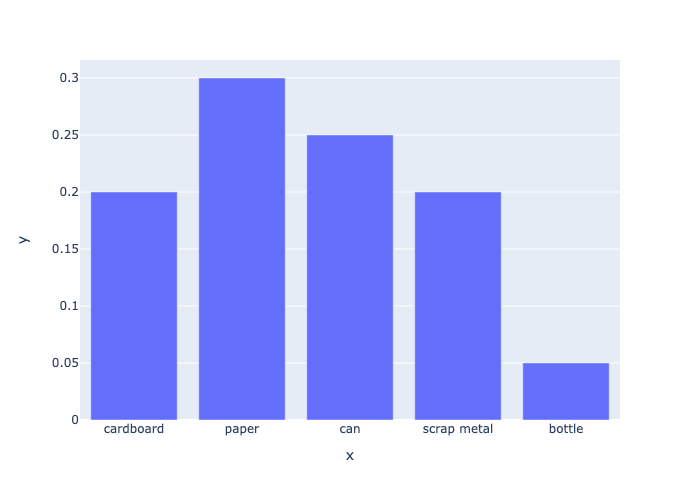

In [8]:
#| caption: A discrete probability distribution as a bar graph.
#| label: fig:discrete-distribution
px.bar(y=PMF, x=categories)

## Simulation by Sampling

> We can simulate our trash sorting cell by sampling from the prior.

```{index} simulation, sampling
```

Suppose we wish to simulate our trash sorting system such that the behavior of the simulation matches, 
in some statistical sense, the behavior of the actual system.
In our case, this amounts to generating samples from the probability distribution
on trash categories.
In particular, we would like to generate a sequence of categories,
$\omega_1, \omega_2, \dots, \omega_n$ such that 
$\omega_i = \mathrm{cardboard}$ approximately 25% of the time,
$\omega_i = \mathrm{paper}$ approximately 20% of the time, etc.
How can we write a computer program to do this?

```{index} uniform probability distribution
```

While most programming libraries do not include functions to generate samples from an arbitrary distribution,
almost all include a random number generator that will generate a random number from the unit interval.
We denote by $U(a,b)$ the *uniform probability distribution* on the interval $[a,b]$.
In numpy, the function `np.random.rand()` generates a sample $x \sim U(0,1)$. We will often use the symbol $\sim$ to indicate a variable is sampled from a given distribution.
Below we explain how we can use this to generate a sample from an arbitrary probability distribution.

### Cumulative Distribution Function
```{index} pair: cumulative distribution function; CDF
```
```{index} random variable
```

We begin by introducing the Cumulative Distribution Function (CDF) for a random variable $X$.
We will more carefully introduce the notion of a discrete random variable in Section 2.2, but for now it
is sufficient to know that a discrete random variable takes values from a countable set,
each of which is assigned a probability value.
For a random variable $X$, the CDF for $X$ is denoted by $F_X$, and is defined as
\begin{equation}
F_X(\alpha) = P(X \leq \alpha)
\end{equation}
It follows immediately that $0 \leq F_X(\alpha) \leq 1$,
since $F_X(\alpha)$ is itself a probability.
In the case of discrete random variables,
say $X \in \{ x_0, \dots x_{n-1}\}$, we can compute the CDF
$F_X(\alpha)$ by summing the probabilities assigned
to all $x_i \leq \alpha$
\begin{equation}
F_X(\alpha) = \sum_{x_i \leq \alpha} P(x_i) = \sum_{i=0}^{k-1} P(x_i)
\end{equation}
in which the rightmost summation follows if we choose $k$ such that $x_{k-1} \leq \alpha < x_k$.
The terminology *Cumulative Distribution Function* stems from the fact that $F_X(\alpha)$
is the accumulated probability assigned to all outcomes less than or equal to $\alpha$,
which is apparent in these summation expressions.

But what does this have to do with generating samples from our distribution on categories?
The idea is simple: we can generate $x\sim U(0,1)$, and a CDF takes on values in the
interval $[0,1]$.  For a discrete random variable $X \in \{ x_0, \dots x_{n-1}\}$
the probability that our sample $x$ corresponds to category $k$
is exactly equal to $F_X(x_k) - F_X(x_{k-1})$, and we define $F_X(x_k)=0$ for $k < 0$.

To see this, we impose an ordering on our categories,
\begin{align*}
c_0 &= \mathrm{cardboard} \\
c_1 &= \mathrm{paper} \\
c_2 &= \mathrm{can} \\
c_3 &= \mathrm{scrap \; metal} \\
c_4 &= \mathrm{bottle}
\end{align*}
and we define the random variable $X \in \{ 0,1,2,3,4\}$ to be the index of the chosen category.
The CDF for $X$ is given by:

| $k$ | $x_k$ | $F_X$($x_k$) |
|----|----------------|:------:|
| 0 | cardboard    |   0.20 |
| 1 | paper    |   0.50 |
| 2 | can    |   0.75 |
| 3 | scrap metal    |   0.95 |
| 4 | bottle    |   1.00 |

### Example
Some numpy code to generate the CDF:

In [9]:
CDF = np.cumsum(PMF)
print(CDF)

[0.2  0.5  0.75 0.95 1.  ]



Now, suppose we generate a random sample $x \sim U(0,1)$,
and use this $x$ to choose category $k$ such that $F_X(x_{k-1}) < x \leq F_X(x_k)$.
For example, we choose category 4 if $0.95 < x \leq 1.0$.
In this case, what is the probability of choosing category 4?
The answer follows from the fact that,
for the uniform distribution on the unit interval, $P(X \in [a,b]) = b-a$.
Therefore, the probability that our sample lies in the interval $[0.95,1.0]$ is
$0.05$, which happens to be exactly the prior probability assigned to category 4!
Likewise, if our sample $x$ satisfies $0.2 < x \leq 0.5$,
we choose category 1, and the probability that our sample lies in the interval
$[0.2,0.5]$ is $0.3$, which is, as expected, exactly the prior probability assigned
to category 1.


The code to accomplish sampling is:

In [10]:
def sample():
    u = np.random.rand()
    for category in range(5):
        if u<float(CDF[category]):
            return category

If we simulate our system by generating a large number of samples, we expect that the frequencies of each category will approximate their prior probabilities. To see this, the code below generates a histogram for 1000 generated samples. While the histogram values do not exactly match the prior probabilities, we can see that the approximation is quite good.

```{index} histogram
```

We can use the plotly library to plot a set of 1000 samples generated using this method, as a *histogram*. The result is shown in Figure [2.2](#fig:discrete-samples).

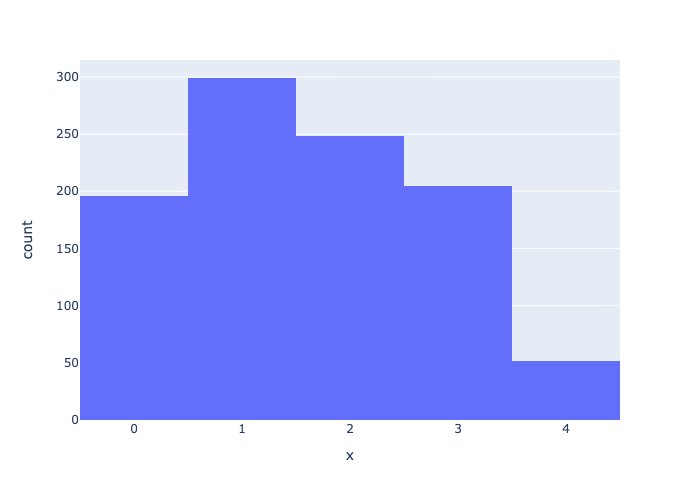

In [11]:
#| caption: A histogram of samples from the discrete distribution.
#| label: fig:discrete-samples
px.histogram(x=[sample() for i in range(1000)])

Of course, GTSAM has all this machinery built-in, and Figure [2.3](#fig:discrete-samples-gtsam) is generated using GTSAM's `DiscreteDistribution.sample` method. Notice that even for a 1000 samples the histograms can look noticeably different because of the variability in sampling.

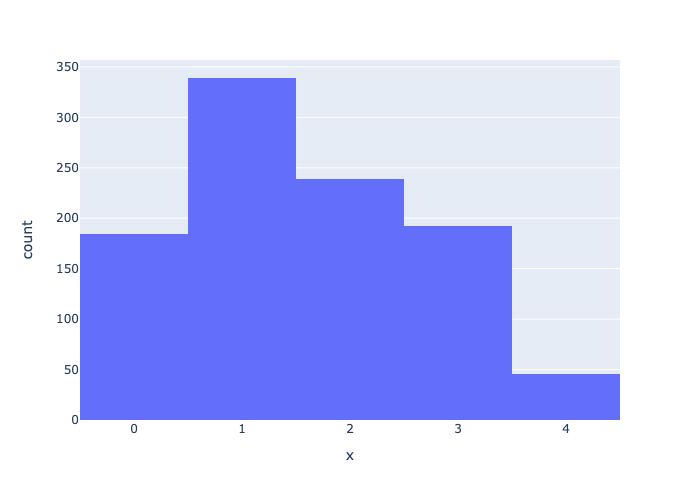

In [12]:
#| caption: The same histogram produced by GTSAM's `DiscreteDistribution.sample` method.
#| label: fig:discrete-samples-gtsam
px.histogram(x=[category_prior.sample() for i in range(1000)])

## GTSAM 101

> The GTSAM concepts used in this section, explained.

Above we created an instance of the `DiscreteDistribution` class. As with any GTSAM class, you can type
```python
help(gtsam.DiscreteDistribution)
```
{raw:tex}`\noindent`
to get documentation on its constructors and methods. In particular, we called the constructor
```python
 __init__(self: gtsam.DiscreteDistribution, key: Tuple[int, int], spec: str) -> None
 ```
{raw:tex}`\noindent`
which expects two arguments (besides `self`, which you can ignore):
- `key`: Many GTSAM objects take a *key* to indicate which variable is involved. In the case of a DiscreteDistribution, the key is actually a tuple of ints:
    - the first int is a 64-bit identifier for the variable;
    - the second int is the *cardinality* of the variable.
- `spec`: The `DiscreteDistribution` class specifies a PMF (remember: probability mass function) which is given as a string of numbers, separated by `/`.

{raw:tex}`\noindent`
Let's look at an example below:

In [13]:
prior = gtsam.DiscreteDistribution((42, 3), "0.4/0.1/0.5")
prior


42,value
0,0.4
1,0.1
2,0.5


```{index} decision tree
```
As you can see, this is a PMF on the variable with id $42$, and it indeed has probabilities (that add up to one) for values `0..2`. Internally, GTSAM *actually* represents a PMF as a small **decision tree**, which you can reveal using `show`, as illustrated in [Figure 2.4](#fig:discrete-decision-tree).

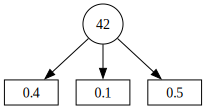

In [14]:
#| caption: The decision tree representation for a discrete probability distribution.
#| label: fig:discrete-decision-tree
show(prior)

Of course, it would be much nicer if we could print out these PMFs in a more readable format, that shows us a name for each variable as well as a pretty name for each. This is where the `Variables` class comes to the rescue. We actually defined a global variable at the top of this notebook, like so:

```python
VARIABLES = Variables()
```

{raw:tex}`\noindent`
which then allows us to give a name to a variable. It will also pick a unique ID for our variable. We can do this with the `discrete` method, which takes a name and a set of value names:

In [15]:
T = VARIABLES.discrete("TresCommas", ["one", "two", "three"])
print(f"key = {T}")

key = (1, 3)


As you can see, the id for the variable is 1 (`Category`, defined above, took id 0), and the cardinality was inferred to be three from the length of the list given as second argument.

The `Variables` class can tell us about any discrete variable so defined, using the two methods `name` and `domain`:

In [16]:
print(f"key = {T}, name = {VARIABLES.name(T)}, domain = {VARIABLES.domain(T)}")


key = (1, 3), name = TresCommas, domain = ['one', 'two', 'three']


Conceptually, the `Variables` class keeps track of the names of variables and what values each variable can take on. We do this so that later when we print, it can show us a beautiful outputs. Of course, this only works if we actually use the key returned to use by `Variables.discrete`. We first define a prior using a string "spec" as shown in [Figure 2.5](#fig:unnormalized-spec). This also illustrates once again that the `spec` string does not need to contain normalized probabilities. The constructor will do the normalization for us! Note that the function `pretty(*)` above is just a shortcut for `gtbook.discrete.pretty(*, VARIABLES)`, and is also defined alongside `VARIABLES`.

In [17]:
#| caption: Creating a `DiscreteDistribution` using an unnormalized "spec".
#| label: fig:unnormalized-spec
prior_on_tres_commas = gtsam.DiscreteDistribution(T, "2/4/2")
pretty(prior_on_tres_commas)

TresCommas,value
one,0.25
two,0.5
three,0.25


Finally, let us also look at the other `DiscreteDistribution` methods we called above:

- `sample(self: gtsam.DiscreteConditional) -> int`: The `sample` method generates samples according to the PMF, returning the integer index of the sampled value, in $0\dots cardinality-1$.
- `pmf(self: gtsam.DiscreteDistribution) -> List[float]`: The `pmf` method will simply return all probability values, in order.
- `__call__(self: gtsam.DiscreteDistribution, arg0: int) -> float`: The call operator: when given an integer value, will return just the one corresponding probability value.

{raw:tex}`\noindent`
We have illustrated the use of all of these in the text, already.

Finally, we can also inspect the value of `VARIABLES`, as it has an HTML representation. The table shown in [Figure 2.6](#fig:nice-Variables-value) lists that we have defined two variables so far, `Category` and `TresCommas`, with respectively six and three possible values, enumerated in the `Domain` column.

In [18]:
#| caption: A value of the `Variables` renders to a nice HTML output.
#| label: fig:nice-Variables-value
VARIABLES

Variable,Domain
Category,"cardboard, paper, can, scrap metal, bottle"
TresCommas,"one, two, three"
